##Klasifikacija listova

Klasifikacija (sistematizacija) je proces organizovanja informacija u kategorije ili klase tako da se podaci mogu jasnije analizirati ili razumeti. 

U ovom radu se vrši klasifikacija listo na osnovu atributa i slika.

Za klasifikaciju na osnovu atributa korišćeni su jedni od najpopularnijih vrsta algoritma, i to su Naive bayes, K-nearest neighbour,Decision tree i Support vector machine.

A za klasifikaciju na osnovu slike korišćene su metode transfer learning-a koristeći modele VGG16[1] i Resnet-50[2]

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Čitanje podataka za klasifikaciju na osnovu atributa


In [144]:
import pandas as pd
import csv
df_train = pd.read_csv('drive/MyDrive/leafs/train.csv')


##Priprema podataka


In [145]:
#provera da li ima praznih kolonna
df_train.isnull().sum()

id           0
species      0
margin1      0
margin2      0
margin3      0
            ..
texture60    0
texture61    0
texture62    0
texture63    0
texture64    0
Length: 194, dtype: int64

In [146]:
#dobijanje broja klasa
df_train['species'].nunique()

99

In [147]:

from sklearn.model_selection import StratifiedShuffleSplit

x_train = df_train.drop(['id','species'],axis = 1)
y_train = df_train['species']



In [148]:
y_train.head()

0              Acer_Opalus
1    Pterocarya_Stenoptera
2     Quercus_Hartwissiana
3          Tilia_Tomentosa
4       Quercus_Variabilis
Name: species, dtype: object

In [149]:
#Kodiranje labela, pošto vrednosti tipa string nisu pogodni za modele
#koristi se LabelEncoding 
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()

y_train = enc.fit_transform(y_train)

In [150]:
X = x_train.values
y = y_train

In [168]:
#Podela training skupa na training i validaciju koristeci stratifikaciju
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2,
                             random_state=0)
sss.get_n_splits(X, y)

5

##Treniranje

In [169]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC,NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.metrics import log_loss

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel='rbf',C = 0.025, probability= True),
    RandomForestClassifier(),
    GaussianNB()
]

In [170]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

log_cols=["Classifier", "Accuracy", "Log Loss"] # created list 
log = pd.DataFrame(columns=log_cols)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(len(y_train))
    print(len(X_train))
    for clf in classifiers:
      name = clf.__class__.__name__
      clf.fit(X_train,y_train)
      #vraca predikciju
      clf_prediction = clf.predict(X_test)
      print(name+" results: ")
      acc = accuracy_score(y_test,clf_prediction)
      print("Accuracy: {:.4%}".format(acc))
      #vraca verovatnocu predikcije
      clf_prediction = clf.predict_proba(X_test)
      ll = log_loss(y_test, clf_prediction)
      print("Log Loss: {}".format(ll))
      log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
      log = log.append(log_entry)
      print('_'*40)
    print("*"*40)
    

792
792
KNeighborsClassifier results: 
Accuracy: 85.8586%
Log Loss: 1.4279539069915295
________________________________________
SVC results: 
Accuracy: 82.3232%
Log Loss: 4.676131753669341
________________________________________
RandomForestClassifier results: 
Accuracy: 97.4747%
Log Loss: 0.7709470977949338
________________________________________
GaussianNB results: 
Accuracy: 55.5556%
Log Loss: 15.350567286627072
________________________________________
****************************************
792
792
KNeighborsClassifier results: 
Accuracy: 83.8384%
Log Loss: 2.3001452300953344
________________________________________
SVC results: 
Accuracy: 80.8081%
Log Loss: 4.687519345905525
________________________________________
RandomForestClassifier results: 
Accuracy: 97.4747%
Log Loss: 0.8008837213152119
________________________________________
GaussianNB results: 
Accuracy: 53.0303%
Log Loss: 16.22275861996375
________________________________________
************************************

##Prikaz rezultata

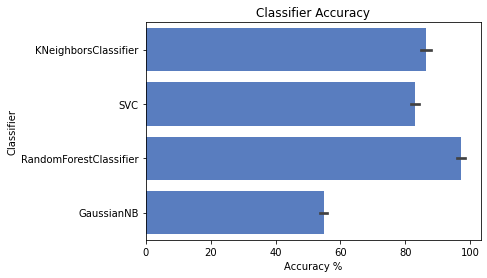

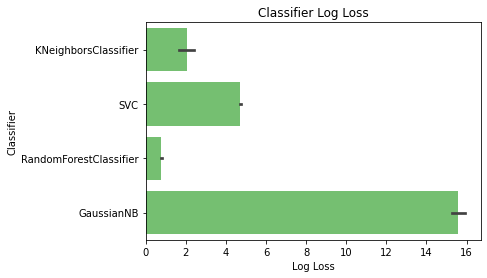

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_color_codes("muted")
sns.barplot(y='Classifier', x='Accuracy', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

##Klasifikacija na osnovu slike

In [96]:
import pandas as pd
import csv
y_df = pd.read_csv('drive/MyDrive/leafs/train.csv',usecols= ['id','species'] ,skip_blank_lines=False, error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


#Ucitavanje podataka

Zbog problema sa csv-om , ne učitavaju se svi redovi, moraju se izbaciti sve slike čiji redovi se nisu učitali.

In [128]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib as plt

from PIL import Image
import glob
from pathlib import Path

INP_SIZE = (224,224)
batch_size = 32

x_train = []
y_train = []
y_list = y_df['id'].tolist();
#Ucitavanje slika 
for f in glob.glob('/content/drive/MyDrive/leafs/images/*.jpg'):
  #Provera da li je red učitan
  if(int(Path(f).stem) in y_list):
    y_train.append(y_df.loc[y_df['id'] == int(Path(f).stem), 'species'].iloc[0])
    image = tf.io.read_file(f)
    image = tf.io.decode_jpeg(image,channels = 3)
    image = tf.image.resize(image, (INP_SIZE[0], INP_SIZE[1]))
    x_train.append(image/255)

x_train = np.array(x_train)


##Priprema podataka

In [130]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


y_train = np.array(y_train)

label_encoder = LabelEncoder()
vec = label_encoder.fit_transform(y_train)

#Kodiranje labela pomocu one hot encoding
y_train = to_categorical(vec, 99)

In [131]:
from sklearn.model_selection import train_test_split

#Podela trening podataka na trening i validaciju

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train,test_size=0.2)

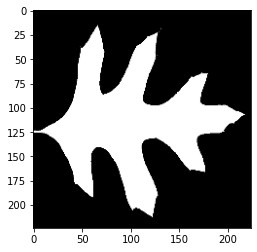

(224, 224, 3)


In [64]:
import matplotlib.pyplot as plt

#Prikaz slike
plt.imshow(x_train[582], cmap='gray', vmin=0, vmax=255)
plt.show()
print(image.shape)

##Kreiranje modela i testiranje

In [133]:
from tensorflow.keras.applications.vgg16 import VGG16

# Učitavanje VGG16 modela
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(INP_SIZE[0], INP_SIZE[1], 3))
base_model.trainable = False

# Prikaz modela bez dodatnih slojeva
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [134]:
from tensorflow.keras import layers, models

#Dodavanje poslednjih slojeva kako bi se model prilagodijo našem cilju 
flatten_layer = layers.Flatten()
dense_layer = layers.Dense(128, activation='relu')
prediction_layer = layers.Dense(99, activation='softmax')

model_vgg16 = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer,
    prediction_layer
])
model_vgg16.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_13 (Flatten)        (None, 25088)             0         
                                                                 
 dense_24 (Dense)            (None, 128)               3211392   
                                                                 
 dense_25 (Dense)            (None, 99)                12771     
                                                                 
Total params: 17,938,851
Trainable params: 3,224,163
Non-trainable params: 14,714,688
_________________________________________________________________


In [135]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

#Podešavanje i treniranje modela
model_vgg16.compile(
    optimizer=Adam(lr=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

#Treniranje modela i pamćenje procesa treniranja radi kasnijeg grafičkog prikaza treniranja kroz epohe
history = model_vgg16.fit(x=x_train,y=y_train,validation_data=(x_valid,y_valid),batch_size = batch_size, epochs=5)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
25/25 [==============================] - 6s 215ms/step - loss: 4.4012 - accuracy: 0.0720 - val_loss: 4.0111 - val_accuracy: 0.1465
Epoch 2/5
25/25 [==============================] - 5s 206ms/step - loss: 3.4053 - accuracy: 0.2677 - val_loss: 3.2314 - val_accuracy: 0.2576
Epoch 3/5
25/25 [==============================] - 5s 207ms/step - loss: 2.5053 - accuracy: 0.4823 - val_loss: 2.5587 - val_accuracy: 0.4697
Epoch 4/5
25/25 [==============================] - 5s 208ms/step - loss: 1.7494 - accuracy: 0.6944 - val_loss: 1.8670 - val_accuracy: 0.6717
Epoch 5/5
25/25 [==============================] - 5s 206ms/step - loss: 1.1674 - accuracy: 0.8371 - val_loss: 1.4397 - val_accuracy: 0.7576


In [139]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

#kreiranje resnet-50 modela
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=99,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [140]:
from tensorflow.keras import layers

#dodavanje poslednjih slojeva
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(layers.Dense(99, activation='softmax'))

resnet_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_14 (Flatten)        (None, 2048)              0         
                                                                 
 dense_26 (Dense)            (None, 512)               1049088   
                                                                 
 dense_27 (Dense)            (None, 99)                50787     
                                                                 
Total params: 24,687,587
Trainable params: 1,099,875
Non-trainable params: 23,587,712
_________________________________________________________________


In [141]:
#treniranje resnet-50 modela
resnet_model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

history2 = resnet_model.fit(x=x_train,y=y_train, validation_data=(x_valid,y_valid), epochs=5)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
25/25 [==============================] - 9s 219ms/step - loss: 4.6701 - accuracy: 0.0227 - val_loss: 4.4772 - val_accuracy: 0.0404
Epoch 2/5
25/25 [==============================] - 3s 129ms/step - loss: 4.1898 - accuracy: 0.1061 - val_loss: 4.1970 - val_accuracy: 0.0707
Epoch 3/5
25/25 [==============================] - 4s 156ms/step - loss: 3.8096 - accuracy: 0.1831 - val_loss: 3.8442 - val_accuracy: 0.1364
Epoch 4/5
25/25 [==============================] - 3s 131ms/step - loss: 3.4168 - accuracy: 0.2500 - val_loss: 3.4571 - val_accuracy: 0.1919
Epoch 5/5
25/25 [==============================] - 3s 131ms/step - loss: 3.0594 - accuracy: 0.3157 - val_loss: 3.1712 - val_accuracy: 0.3081


##Rezultati

In [137]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

##Fukcija za iscrtavanje rezultata
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

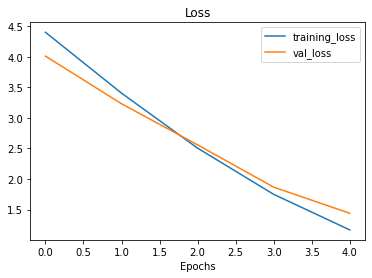

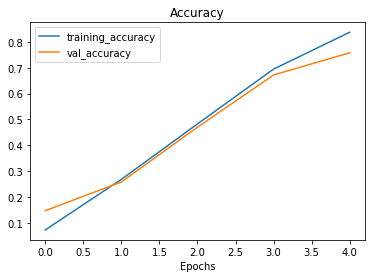

In [138]:
plot_loss_curves(history)

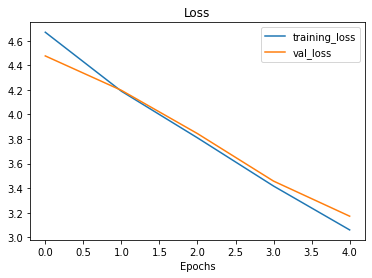

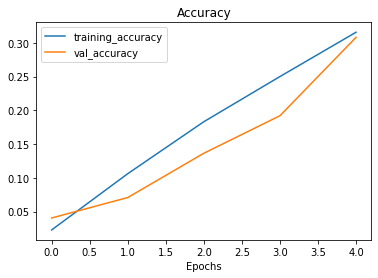

In [143]:
plot_loss_curves(history2)

##Zaključak

U ovom radu su iskorišćeni razni modeli. Kao što se iz rezultata može videti za klasifikaciju na osnovu atributa  najbolje se pokazao RandomForrest algoritam, a za klasifikaciju na osnovu slike VGG-16.

Najveći izazov u ovom zadatku je bila priprema podataka zato što se nisu iščitavali svi redovi pa se prilikom učitavanja slika morale ukloniti slike koje čiji redovi se nisu nalazili u pandas dataframe-u.

## Reference

[1]https://doi.org/10.48550/arXiv.1409.1556

[2]https://doi.org/10.48550/arXiv.1512.03385